In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math

In [246]:
FILENAME = 'augmented_data.csv'

BATCH_SIZE = 128
TRAIN_SPLIT = 0.8

NUM_FEATURES = 24
NUM_UNITS = 32
NUM_USERS = 9
NUM_EPOCHS = 1

EPSILON = 0.1
DELTA = 10**-5
NORM_CLIP=4.0

SIGMA = 0.3

RHO = 0.5

MAP_PARAMS = 2

NUM_GRIDS = 4

## Load Data

In [4]:
userID = {
'a841f74e620f74ec443b7a25d7569545':0,
'22223276ea84bbce3a62073c164391fd':1,
'510635002cb29804d54bff664cab52be':2,
'7cbc37da05801d46e7d80c3b99fd5adb':3,
'7023889b4439d2c02977ba152d6f4c6e':4,
'8425a81da55ec16b7f9f80c139c235a2':5,
'6882f6cf8c72d6324ba7e6bb42c9c7c2':6,
'1e33db5d2be36268b944359fbdbdad21':7,
'892d2c3aae6e51f23bf8666c2314b52f':8,
}

In [5]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
        self.augmented_data = pd.read_csv(csv_file, header=0, usecols = [0]+list(range(2,21))+list(range(22,26)), 
                                          converters={0:lambda x: datestr2num(x)})
        self.userlabels = pd.read_csv(csv_file, header=0, usecols=["iPhoneUID"],converters={"iPhoneUID": lambda x: userID[x]})
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [7]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=True)

In [8]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualize Functions

In [140]:
def show_batch_wlabels(sample_batch,longlines=None,latlines=None):
    with torch.no_grad():
        data, users = sample_batch['x'], sample_batch['u']
        batch_size = len(data)
        colors = users.numpy()[:,0].tolist()
        for i in range(batch_size):
            plt.scatter(data[:,:,13].numpy(), data[:,:,12].numpy(), c=colors)
        if longlines is not None:
            for line in longlines.numpy():
                plt.axvline(line)
        if latlines is not None:
            for line in latlines.numpy():
                plt.axhline(line)

In [64]:
def show_privatizer(x, y, u, uhat, lochat):
    with torch.no_grad():
        fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Input Data")
        ax[1].set_title("Obfuscated Data")
        ax[2].set_title("Adversary Estimate")
        
        ax[0].scatter(x[:,:,13].numpy(),x[:,:,12].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
        ax[1].scatter(y[:,:,13].numpy(),y[:,:,12].numpy())
        _, upred = torch.max(uhat.data,1)
        ax[2].scatter(lochat[:,1].numpy(), lochat[:,0].numpy(),c=upred.numpy())

In [235]:
def show_maps(x, y,npoints=100):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Map from Input Data")
        ax[1].set_title("Map from Obfuscated Data")
        
        grid = torch.empty(npoints,1,2).uniform_(5)-2.5
        tr = [grid[:,:,1]**i*grid[:,:,0]**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)]
        poly_grid = torch.cat(tr,1)
        poly_grid = poly_grid.view(-1,6)
        
        bx = signal_map_params(x,MAP_PARAMS).float()
        by = signal_map_params(y,MAP_PARAMS).float()  
        x_predicted_rss = torch.mm(poly_grid,bx)
        y_predicted_rss = torch.mm(poly_grid,by)
        
        ax[0].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=x_predicted_rss.numpy())
        ax[1].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=y_predicted_rss.numpy())

## Define loss and helper functions

In [245]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean()
    cx,_,_ = density_count(x,NUM_GRIDS)
    cy,_,_ = density_count(y,NUM_GRIDS)
    l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
    l = torch.nn.CrossEntropyLoss()
    l5 = l(uhat,u)
    return RHO*(l1+l2+l3+l4)-(1-RHO)*l5

In [155]:
def poly(degree, long, lat):
    return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)

def signal_map_params(x,degree):    
    polynomial = poly(MAP_PARAMS, x[:,:,13], x[:,:,12])
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,6]))
    return beta

In [15]:
def density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    x1min=torch.min(x[:,:,13])
    x2min=torch.min(x[:,:,12])
    size1 = torch.max(x[:,:,13])-x1min
    size2 = torch.max(x[:,:,12])-x2min
    a_all = []
    c_all = []
    for i in range(num_grids):
        for j in range(num_grids):
            a = x1min+(size1/num_grids*i)
            a_all.append(a)
            b = x1min+(size1/num_grids*(i+1))
            a_all.append(b)
            c = x2min+(size2/num_grids*j)
            c_all.append(c)
            d = x2min+(size2/num_grids*(j+1))
            c_all.append(d)
            if i == num_grids-1 and j != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
            elif j == num_grids-1 and i != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            elif j == num_grids-1 and i == num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            else:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
    return count, torch.unique(torch.Tensor(a_all)), torch.unique(torch.Tensor(c_all))

In [105]:
def adversary_loss(u,x,uhat,lochat):
    l = torch.nn.CrossEntropyLoss()
    dist = (x[:,:,12:14]-lochat).pow(2).mean()
    spread = (x[:,:,12:14].std(dim=0)-lochat.std(dim=0)).pow(2).mean()
    return 2*l(uhat,u)+dist+4*spread

## Define adversary

In [135]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    # also recover original lat and long
    torch.nn.Linear(NUM_UNITS, NUM_USERS+2)
)
adversary.double()

Sequential(
  (0): Linear(in_features=24, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=11, bias=True)
)

In [97]:
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

## Define privatizers

#### GAP

In [20]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

#### Local DP

In [21]:
def dp_privatizer(x):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    sigma = (NORM_CLIP/EPSILON)*math.sqrt(2*math.log(1.25/DELTA))
    noise = torch.normal(mean=torch.zeros_like(x),std=sigma).double()
    y = x + noise
    return y

#### Gaussian Noise

In [22]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

# TRAIN

In [136]:
PRIVATIZER = gap_privatizer

In [241]:
# for each epoch
for epoch in range(NUM_EPOCHS):
    
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs and original locations
        estimate = adversary(x).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # train adversary
        aloss = adversary_loss(u,x,uhat,lochat)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
        if i % 100 == 99:
            print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 1000:
            break
print("done")

100 aloss: 8.973417587259195 ploss: 1.2380676189018494
200 aloss: 10.369637458823838 ploss: 1.20915287874884
300 aloss: 8.815765861544822 ploss: 1.3273090625617407
400 aloss: 9.743462300246332 ploss: -0.02397414714442503
500 aloss: 9.092195135688652 ploss: 1.467421027115574
600 aloss: 8.919825030592433 ploss: -0.20635925325561377
700 aloss: 8.35678390818259 ploss: 0.7870229877361474
800 aloss: 9.000010845262064 ploss: 2.4381697918176544
900 aloss: 8.73172446928789 ploss: 1.9789494513048873
1000 aloss: 8.638099069782413 ploss: 2.206361986975344
done


# Test

In [242]:
# do not keep track of gradients
with torch.no_grad():
    correct = 0
    total = 0
    dist_error = 0
    l1,l2,l3,l4,l5 = 0,0,0,0,0
    
    # iterate through test data
    for i,batch in enumerate(test_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # estimate userID and location
        estimate = adversary(x).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # Privacy Metric
        _, upred = torch.max(uhat.data,1)
        total+=u.size(0)
        correct+=(upred==u).sum().item()
        dist_error += (x[:,:,12:14]-lochat).pow(2).mean().item()
        
        # Utility Metrics
        l = torch.nn.CrossEntropyLoss()
        l5 += l(uhat,u).item()
        bx = signal_map_params(x,MAP_PARAMS)
        by = signal_map_params(y,MAP_PARAMS)
        l1 += (bx-by).pow(2).mean().item()
        l2 += (y-x).pow(2).mean().item()
        l3 += (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean().item()
        cx,_,_ = density_count(x,NUM_GRIDS)
        cy,_,_ = density_count(y,NUM_GRIDS)
        l4 += (cx-cy).pow(2).mean().item()/BATCH_SIZE
        
        # stop early
        if i==3:
            break
        
    print("Adversary Accuracy:", 100*correct/total)
    print("Average estimated location error:",dist_error/(i+1))
    print("")
    
    print("Adversary Loss:", l5/(i+1))
    print("Sigmal Map:", l1/(i+1))
    print("Distortion:", l2/(i+1))
    print("Geographic Distortion:", l3/(i+1))
    print("Density Count:",l4/(i+1))

Adversary Accuracy: 15.0390625
Average estimated location error: 0.8116996088204971

Adversary Loss: 2.2378244522043045
Sigmal Map: 0.04576525696000182
Distortion: 0.3898362879229863
Geographic Distortion: 0.3191566598363794
Density Count: 2.8531494140625


# Visualize

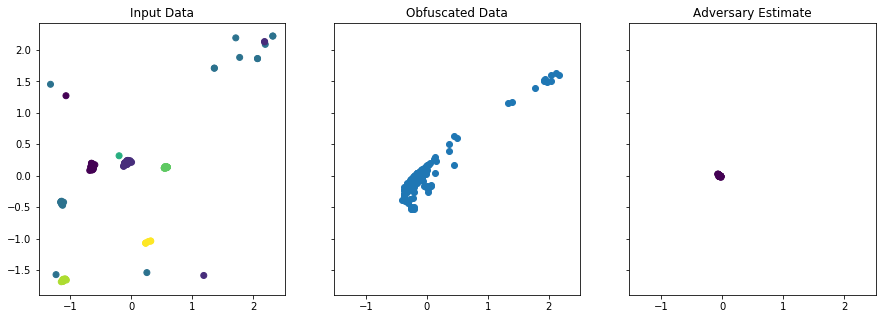

In [243]:
show_privatizer(x,y,u,uhat,lochat)

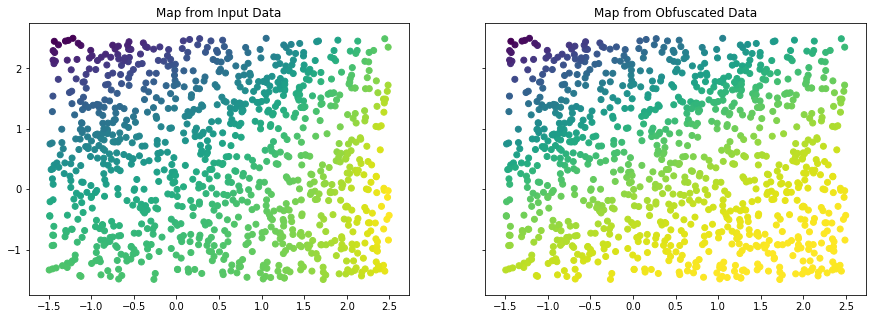

In [244]:
show_maps(x,y,1000)